In [0]:
!pip install tensorflow==2.0.0-rc1

     |████████████████████████████████| 86.3MB 542kB/s 
     |████████████████████████████████| 4.3MB 30.5MB/s 
     |████████████████████████████████| 501kB 42.3MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [1]:
%%time
from __future__ import unicode_literals, print_function, absolute_import, division

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.enable_eager_execution()
from tensorflow import keras
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

try:
  %tensorflow_version 2.x
except:
  pass

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

TensorFlow is already loaded. Please restart the runtime to change versions.
CPU times: user 2.13 s, sys: 307 ms, total: 2.43 s
Wall time: 3.8 s


In [0]:
tf.__version__

'2.0.0-rc1'

In [2]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


In [3]:
print(raw_train)
print(raw_validation)
print(raw_test)

<DatasetV1Adapter shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>


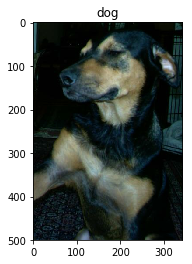

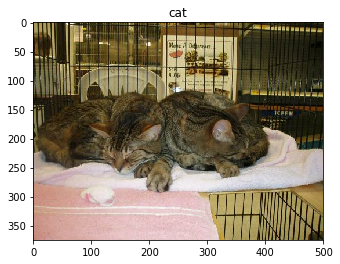

In [4]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [0]:
IMG_SIZE = 160
def format_example(image, labels):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [0]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [8]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([Dimension(32), Dimension(160), Dimension(160), Dimension(3)])

In [9]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights="imagenet")

9412608/9406464 [==============================] - 0s 0us/step


In [10]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [0]:
base_model.trainable = False

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

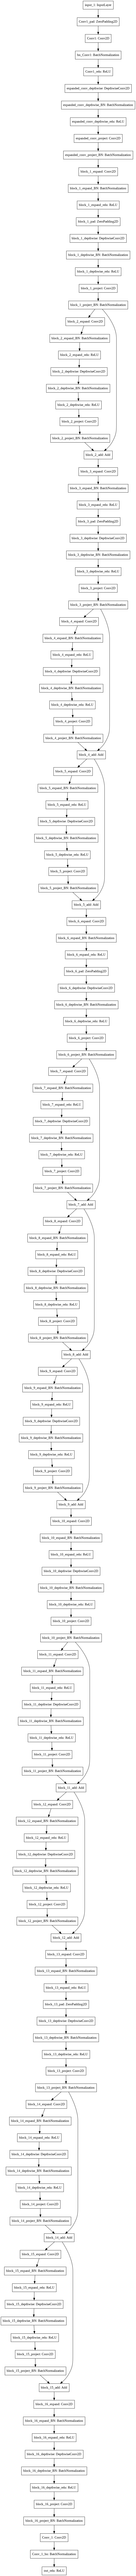

In [13]:
keras.utils.plot_model(base_model)

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [15]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [0]:
model = tf.keras.Sequential([
                             base_model, 
                             global_average_layer,
                             keras.layers.Dropout(0.5),
                             prediction_layer
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


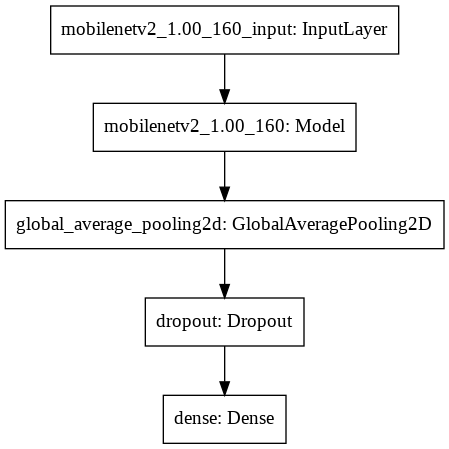

In [18]:
keras.utils.plot_model(model)

In [0]:
base_learning_rate = 0.001
model.compile(optimizer=keras.optimizers.RMSprop(lr=base_learning_rate),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [20]:
len(model.trainable_variables)

2

In [0]:
num_train, num_val, num_test = (
    metadata.splits['train'].num_examples*weight/10 for weight in SPLIT_WEIGHTS
)

In [22]:
print(num_train)
print(num_val)
print(num_test)

18609.6
2326.2
2326.2


In [0]:
initial_epochs = 1
steps_per_epoch = round(num_train)//64
validation_steps=20

In [25]:
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 5s 238ms/step - loss: 1.0971 - acc: 0.8203


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.10
initial accuracy: 0.82


In [27]:
history = model.fit(train_batches,
                    epochs=2,
                    validation_data=validation_batches)

Epoch 1/2
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


582/582 [==============================] - 103s 177ms/step - loss: 0.0078 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/2
582/582 [==============================] - 97s 166ms/step - loss: 8.0555e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000


In [28]:
loss, accuracy = model.evaluate(validation_batches, steps=validation_steps)

20/20 [==============================] - 3s 143ms/step - loss: 0.0000e+00 - acc: 1.0000


In [31]:
loss, accuracy = model.evaluate(test_batches)

     73/Unknown - 10s 131ms/step - loss: 0.0000e+00 - acc: 1.0000

[0.0, 1.0]